# Why this notebook?
After reading and applying the concepts of the second chapter of the book Hands-on Machine Learning by Auréline Géron, I want to test my understanging. I'll replicate the end to end project on a new dataset.

# Goal
Predict a person medical insurance's charge.

# Retrieving data

In [57]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mirichoi0218/insurance")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/d/mirichoi0218/insurance


In [58]:
file_path = "/kaggle/input/d/mirichoi0218/insurance/insurance.csv"
insurance = pd.read_csv(file_path)

insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [59]:
insurance.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

# Separate the dataset
We now need to separate the dataset into two then two datasets. The first separation is to get the labels on one hand (what we want to predict) and the data on the other hand (what we'll use to predict). The second one is to get training data, and test data. We don't want our model to train on the test data to avoid overfitting.

In [60]:
# First separation
X = insurance.drop("charges", axis=1)
y = insurance["charges"]

In [61]:
# Second separation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Discover the data
We know want to discover and visualize the data to gain insights.

The single most important part of the data is the label repartition.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

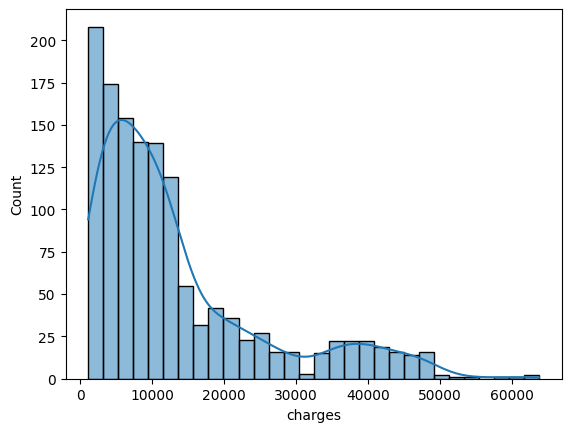

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=insurance["charges"], label="charges", kde=True)

It's skewed, most charges are low. We'll have to keep in mind when we train our model.

## Categorical data
Since it's pretty hard to work with categorical data (not a number) we're going to use boxplot to see how they affect the charges.

<Axes: xlabel='smoker', ylabel='charges'>

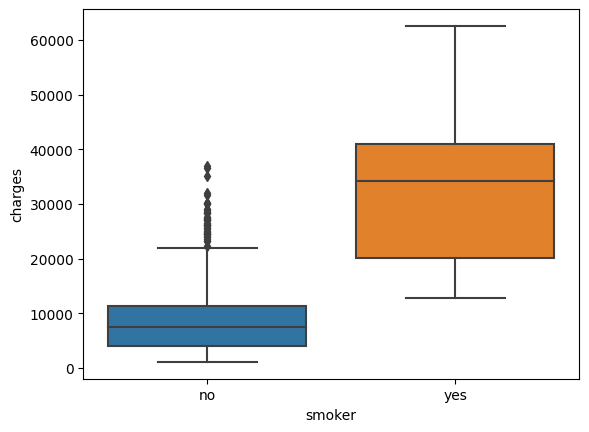

In [63]:
# Do smoker pay more?
sns.boxplot(x=X_train["smoker"], y=y_train)

<Axes: xlabel='sex', ylabel='charges'>

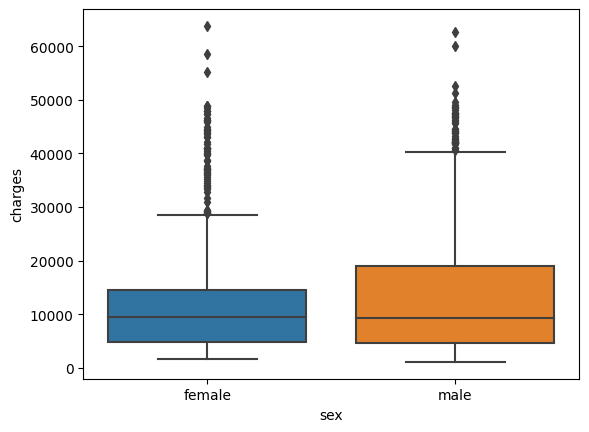

In [64]:
# Does sex affect the charges?
sns.boxplot(x="sex", y="charges", data=insurance)

<Axes: xlabel='region', ylabel='charges'>

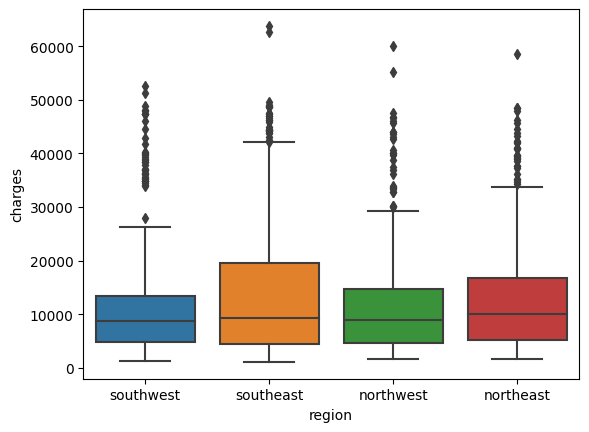

In [65]:
# Do charges depend on region?
sns.boxplot(x="region", y="charges", data=insurance)

## Numerical data
Visualizing correlation between numerical data and the charges is equally important.

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


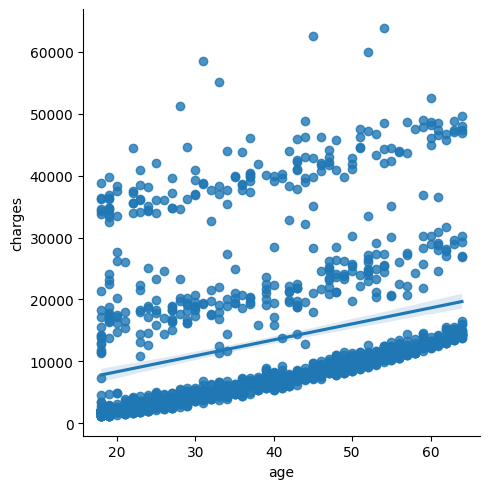

In [66]:
sns.lmplot(x="age", y="charges", data=insurance)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


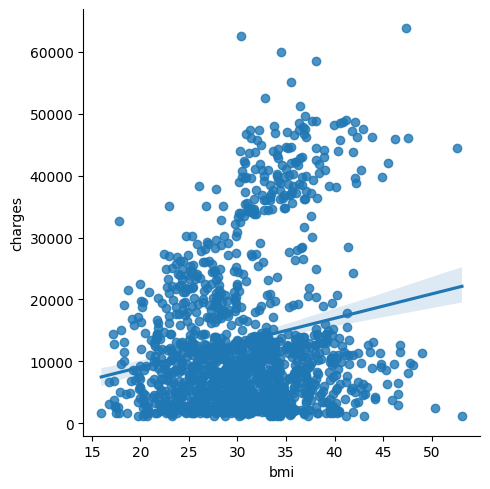

In [67]:
sns.lmplot(x="bmi", y="charges", data=insurance)

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


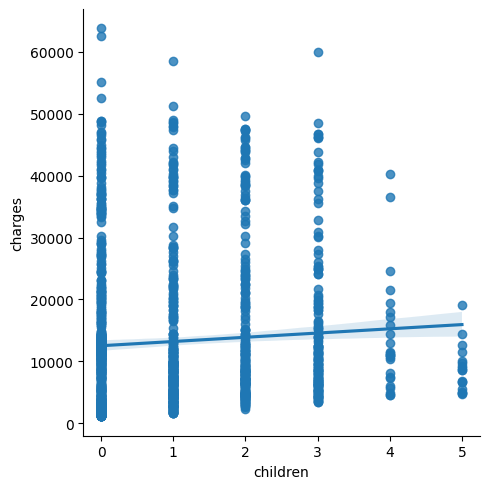

In [68]:
sns.lmplot(x="children", y="charges", data=insurance)

# Cleaning the data
We got our visuals, I don't see any new feature emerging from the existing one, so the next step is to clean the data. Since the dataset doesn't have any null values, or any weird values (200 children, or someone -2 years old), we can take care of the outliers.
Regression models don't like outliers because they'll try very hard not to be wrong for them, but become wrong for the normal values.

In [69]:
# compress high value charges
import numpy as np
# We don't have any charges at 0, but it might happen in the future, log1p avoid any error
y_train_log = np.log1p(y_train)
y_train_log.describe()

count    1070.000000
mean        9.113489
std         0.911454
min         7.023647
25%         8.496718
50%         9.167061
75%         9.726009
max        11.044423
Name: charges, dtype: float64

We also need to change our categorical features into numerical features. Using `OneHotEncoder` will create an array, for each value x of the feature, where all the values are at 0 except x.

In [70]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# The numerical pipeline
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

# The categorical pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

Let's combine our two pipelines.

In [71]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

X_train_prepared = preprocessing.fit_transform(X_train)
# DO NOT CALL FIT ON THE TEST DATA -> LEAKAGE
X_test_prepared = preprocessing.transform(X_test)